In [ ]:
import torch
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from collections import defaultdict

In [ ]:
# cpu_gpu_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# #cpu_gpu_device = torch.device('cpu')
# print(f"Using device: {cpu_gpu_device}")

In [ ]:
def print_dict(md):
    for k, v in md.items():
        print(f'{k} -> {v}')
def print_cluster(cluster):
    print(f'ID: {cluster.cluster_id}')
    print(f'Size: {cluster.size}')
    print(f'Children: {len(cluster.children)}')
    print(f'Nodes: {cluster.nodes_ids}')
    print(f'Lambda Death: {cluster.lambda_death}')
    print(f'Lambdas: {cluster.nodes_lambdas}')
    print(f'Cluster Persistence: {cluster.persistence}')

# * MyHDBScan

## ** MST

In [ ]:
class MST:
    def __init__(
            self,
            number_of_nearest_neighbors=5,
            cpu_gpu_device='cpu',
            ):
        # number of nearest neighbors
        self.k = number_of_nearest_neighbors
        self.cpu_gpu_device = cpu_gpu_device

    def mutual_reachability_distance(self, X):
        """
        Compute the mutual reachability distance matrix using PyTorch and CUDA.
        """
        X = torch.tensor(X, dtype=torch.float32, device=self.cpu_gpu_device)  # Move data to device
        pairwise_dist = torch.cdist(X, X)  # Compute pairwise Euclidean distances
        knn_distances, _ = torch.topk(pairwise_dist, self.k + 1, largest=False)  # k-NN distances
        core_distances = knn_distances[:, -1].unsqueeze(1)  # Core distance is k-th neighbor

        # Compute mutual reachability distance
        mutual_dist_matrix = torch.max(pairwise_dist, core_distances)
        self.mutual_dist_matrix = torch.max(mutual_dist_matrix, core_distances.T)

    def minimum_spanning_tree(self):
        """
        Compute the Minimum Spanning Tree using Kruskal’s algorithm in PyTorch.
        """
        n = self.mutual_dist_matrix.shape[0]
        triu_indices = torch.triu_indices(n, n, 1, device=self.cpu_gpu_device)  # Get upper-triangle indices
        edge_weights = self.mutual_dist_matrix[triu_indices[0], triu_indices[1]]  # Extract edge weights
        sorted_indices = torch.argsort(edge_weights)  # Sort edges by weight

        parent = torch.arange(n, device=self.cpu_gpu_device)  # Union-Find structure

        def find(x):
            while parent[x] != x:
                x = parent[x]
            return x

        self.mst_edges = []
        for idx in sorted_indices:
            u, v = triu_indices[:, idx]
            root_u, root_v = find(u), find(v)

            if root_u != root_v:  # No cycle condition
                self.mst_edges.append((u.item(), v.item(), edge_weights[idx].item()))
                parent[root_v] = root_u

                if len(self.mst_edges) == n - 1:
                    break

    def get_mst_edges(self, X):
        self.mutual_reachability_distance(X)
        self.minimum_spanning_tree()
        return self.mst_edges

## ** clastering

In [ ]:
class Cluster:
    def __init__(
            self,
            cluster_id,
            death_size,
            size,
            lambda_birth=None,
            lambda_death=None,
            children=[],
            nodes_ids=[],
            nodes_lambdas=[],
            persistence=0,
            is_singleton = False
    ):
        self.cluster_id = cluster_id
        self.final_id = cluster_id
        self.death_size = death_size
        self.size = size
        self.lambda_birth = lambda_birth
        self.lambda_death = lambda_death
        self.children = children
        self.nodes_ids = nodes_ids
        self.nodes_lambdas = nodes_lambdas
        self.persistence = persistence
        self.is_singleton = is_singleton


class DisjointSet:
    def __init__(self, n_points, min_cluster_size):
        self.parents = list(range(n_points))
        # For Union-Find optimization (tree height)
        self.clusters_ranks = [0] * n_points

        self.n_points = n_points
        self.min_cluster_size = min_cluster_size or n_points

        # Initialize singletons clusters
        self.clusters_hierarchy = {}
        for i in range(self.n_points):
            self.clusters_hierarchy[i] = Cluster(
                cluster_id=i,
                death_size=0,
                size=1,
                nodes_ids=[i],
                is_singleton=True
            )
        # final clusters
        self.final_clusters = set()

        self.debugging_history = []

    def find(self, u):
        if self.parents[u] != u:
            self.parents[u] = self.find(self.parents[u])  # Path compression
        return self.parents[u]

    def union(self, root_u, root_v):
        if self.clusters_ranks[root_u] < self.clusters_ranks[root_v]:
            root_u, root_v = root_v, root_u
        self.parents[root_v] = root_u
        # Rank increases only if equal height
        if self.clusters_ranks[root_u] == self.clusters_ranks[root_v]:
            self.clusters_ranks[root_u] += 1
        return root_u, root_v

    def calculate_persistence(self, cluster):
        """
        Calculate persistence for each cluster.
        """
        if cluster.death_size:
            delta_lambda = cluster.lambda_death - cluster.lambda_birth
            # persistance of existing nodes
            cluster.persistence += cluster.death_size * delta_lambda
        # persistance of fall off nodes
        if len(cluster.nodes_lambdas) > 0:
            nodes_lambdas = np.array(cluster.nodes_lambdas)
            cluster.persistence += np.sum(nodes_lambdas - cluster.lambda_birth)
        cluster.nodes_lambdas = []

    # Flatten hierarchy
    def collapse_cluster(self, cluster):
        self.calculate_persistence(cluster)
        if cluster.children == []:
            return  # Wait for parent comparison

        children_persistence = sum(ch.persistence for ch in cluster.children)
        # compare persistences
        if cluster.persistence > children_persistence:
            clusters_to_delete = []
            nodes_ids = []

            def collect_nodes_and_ids(clust):
                nonlocal nodes_ids # Required for extend
                for ch in clust.children:
                    collect_nodes_and_ids(ch)
                    clusters_to_delete.append(ch.cluster_id)
                nodes_ids.extend(clust.nodes_ids)

            collect_nodes_and_ids(cluster)
            cluster.nodes_ids = nodes_ids
            cluster.children = []

            # Delete after traversal
            for cid in clusters_to_delete:
                del self.clusters_hierarchy[cid]
                self.final_clusters.discard(cid)
            # Add to final clusters
            self.final_clusters.add(cluster.final_id)

        else:
            cluster.persistence = children_persistence
            cluster.final_id = None
            # Add to final clusters
            for ch in cluster.children:
                self.final_clusters.add(ch.final_id)

    # merge 2 singletons
    def merge_the_singletons(self, cluster_u, cluster_v, lambda_val):
        cluster_u.death_size = 0
        cluster_u.size = 2
        cluster_u.nodes_ids.extend(cluster_v.nodes_ids)
        cluster_u.nodes_lambdas = [lambda_val, lambda_val]
        cluster_u.is_singleton = False
        del self.clusters_hierarchy[cluster_v.cluster_id]

    # cluster_u absorbs cluster_v
    def absorb_cluster(self, cluster_u, cluster_v):
        cluster_u.size += cluster_v.size
        cluster_u.nodes_ids.extend(cluster_v.nodes_ids)
        cluster_u.nodes_lambdas.extend(cluster_v.nodes_lambdas)
        del self.clusters_hierarchy[cluster_v.cluster_id]

    # cluster_u and cluster_v merged into new cluster
    def merge_clusters(self, cluster_u, cluster_v, lambda_val, cluster_id):
        cluster_u.lambda_birth = lambda_val
        self.collapse_cluster(cluster_u)
        cluster_v.lambda_birth = lambda_val
        self.collapse_cluster(cluster_v)
        size = cluster_u.size + cluster_v.size
        children = [cluster_u, cluster_v]
        self.clusters_hierarchy[cluster_id] = Cluster(
            cluster_id=cluster_id,
            death_size=size,
            size=size,
            lambda_death=lambda_val,
            children=children
        )

    def build_hierarchy(self, mst_edges):
        """
        Build hierarchy from MST
        Args:
            mst_edges: List of [(u, v, distance), ...] sorted by increasing distance
        """
        epsilon = 1e-10
        # Initialize trackers
        root_clusters_map = {i: i for i in range(self.n_points)}

        # Start assigning new IDs after original points
        cluster_id = self.n_points - 1
        # Process MST edges in order of increasing distance
        for u, v, distance in mst_edges:
            # Lambda = inverse of distance
            lambda_val = 1 / distance
            #lambda_val = 1 / (distance + epsilon)
            #lambda_val = -np.log(lambda_val + epsilon)
            root_u, root_v = self.find(u), self.find(v)

            debug_dict = {
                'u': u,
                'v': v
            }

            if root_u != root_v:
                # Unite the clusters
                root_u, root_v = self.union(root_u, root_v)
                # Get the clusters
                u_id = root_clusters_map[root_u]
                cluster_u = self.clusters_hierarchy[u_id]
                v_id = root_clusters_map[root_v]
                cluster_v = self.clusters_hierarchy[v_id]
                # Absorb or merge
                if cluster_u.size < self.min_cluster_size or cluster_v.size < self.min_cluster_size:
                    if cluster_u.is_singleton:
                        debug_dict['action'] = 'merge_the_singletons'
                        debug_dict['u_nodes'] = cluster_u.nodes_ids.copy()
                        debug_dict['v_nodes'] = cluster_v.nodes_ids.copy()

                        self.merge_the_singletons(
                            cluster_u=cluster_u,
                            cluster_v=cluster_v,
                            lambda_val=lambda_val
                        )

                        debug_dict['cluster_nodes'] = cluster_u.nodes_ids.copy()
                        debug_dict['size'] = cluster_u.size
                        debug_dict['cluster_id'] = cluster_u.cluster_id
                        debug_dict['final_id'] = cluster_u.final_id
                    else:
                        debug_dict['action'] = 'absorb'
                        debug_dict['u_nodes'] = cluster_u.nodes_ids.copy()
                        debug_dict['v_nodes'] = cluster_v.nodes_ids.copy()

                        self.absorb_cluster(
                            cluster_u=cluster_u,
                            cluster_v=cluster_v
                        )

                        debug_dict['cluster_nodes'] = cluster_u.nodes_ids.copy()
                        debug_dict['size'] = cluster_u.size
                        debug_dict['cluster_id'] = cluster_u.cluster_id
                        debug_dict['final_id'] = cluster_u.final_id

                    # Update cluster map
                    root_clusters_map[root_u] = cluster_u.cluster_id
                else:
                    # Increment cluster ID and update cluster map
                    cluster_id += 1
                    root_clusters_map[root_u] = cluster_id
                    # Merge the clusters

                    debug_dict['action'] = 'merge'
                    debug_dict['u_nodes'] = cluster_u.nodes_ids.copy()
                    debug_dict['v_nodes'] = cluster_v.nodes_ids.copy()

                    self.merge_clusters(
                        cluster_u=cluster_u,
                        cluster_v=cluster_v,
                        lambda_val=lambda_val,
                        cluster_id=cluster_id
                    )

                    debug_dict['cluster_nodes'] = cluster_u.nodes_ids.copy()
                    debug_dict['size'] = cluster_u.size
                    debug_dict['cluster_id'] = cluster_u.cluster_id
                    debug_dict['final_id'] = cluster_u.final_id

                # # delete old cluster pointer
                # del root_clusters_map[root_v]
                root_id = root_clusters_map[root_u]

            self.debugging_history.append(debug_dict)

        # root_cluster = self.clusters_hierarchy[root_id]
        # root_cluster.lambda_birth = 0
        # self.collapse_cluster(root_cluster)
        self.final_clusters.discard(None)

    def get_clusters_dict(self):
        clusters_dict = {}
        for cluster_id in self.final_clusters:
            nodes_ids = self.clusters_hierarchy[cluster_id].nodes_ids
            clusters_dict[cluster_id] = nodes_ids
        return clusters_dict

## ** modifications

In [ ]:
# ver 1
class Cluster:
    def __init__(
            self,
            size,
            lambda_birth=None,
            lambda_death=None,
            children=[],
            nodes=[],
            persistence = 0,
            is_node = False
    ):
        self.size = size
        self.lambda_birth = lambda_birth
        self.lambda_death = lambda_death
        self.children = children
        self.nodes = nodes
        self.persistence = persistence
        self.is_node = is_node

class DisjointSet:
    def __init__(self, n_points, min_cluster_size):
        self.parents = list(range(n_points))
        # For Union-Find optimization (tree height)
        self.clusters_ranks = [0] * n_points
        # Track size of each cluster
        self.clusters_sizes = [1] * n_points

        self.n_points = n_points
        self.min_cluster_size = min_cluster_size

        # Initialize singletons clusters
        self.clusters = {}
        for i in range(self.n_points):
            self.clusters[i] = Cluster(
                size=1,
                nodes=[i],
                is_node=True
            )

    def find(self, u):
        if self.parents[u] != u:
            self.parents[u] = self.find(self.parents[u])  # Path compression
        return self.parents[u]

    def union(self, root_u, root_v):
        if self.clusters_ranks[root_u] < self.clusters_ranks[root_v]:
            root_u, root_v = root_v, root_u
        self.parents[root_v] = root_u
        # Update size
        self.clusters_sizes[root_u] += self.clusters_sizes[root_v]
        # Rank increases only if equal height
        if self.clusters_ranks[root_u] == self.clusters_ranks[root_v]:
            self.clusters_ranks[root_u] += 1
        return root_u

    def build_hierarchy(self, mst_edges):
        """
        Build hierarchy from MST
        Args:
            mst_edges: List of [(u, v, distance), ...] sorted by increasing distance
        """

        # Initialize trackers
        active_clusters = set(range(self.n_points))
        root_clusters_map = {i: i for i in range(self.n_points)}

        # Start assigning new IDs after original points
        cluster_id = self.n_points - 1
        # Process MST edges in order of increasing distance
        for u, v, distance in mst_edges:
            # increment cluster ID
            cluster_id += 1
            # Lambda = inverse of distance
            lambda_val = 1 / distance
            root_u, root_v = self.find(u), self.find(v)

            if root_u != root_v:
                children = []
                for root in (root_u, root_v):
                    active_clusters.discard(root)
                    # Update children
                    child_id = root_clusters_map[root]
                    children.append(child_id)
                    # update lambda_birth
                    child_cluster = self.clusters[child_id]
                    child_cluster.persistance = child_cluster.lambda_death - lambda_val


                # Merge clusters
                new_root = self.union(root_u, root_v)

                active_clusters.add(new_root)
                root_clusters_map[new_root] = cluster_id

                self.clusters[cluster_id] = Cluster(
                    size=self.clusters_sizes[new_root],
                    lambda_death=lambda_val,
                    children=children,
                )

        self.clusters[cluster_id].lambda_birth = 0

    def condense_and_compute_persistence(self):
        """
        Condense hierarchy and compute persistence for significant clusters.
        """
        self.condensed_tree = []
        self.persistence = {}
        # Track clusters already processed for persistence

        for event in self.merge_events:
            cluster_size = event['size']

            # Include in condensed tree if the new cluster is significant
            if cluster_size >= self.min_cluster_size:
                # Compute persistence only once per significant cluster
                cluster_id = event['cluster_id']
                # First birth when it becomes significant
                lambda_birth = event['lambda_birth']
                # Final death from clusters_lambdas
                root = event['root']
                lambda_death = self.clusters_lambdas[root][-1][1]
                self.persistence[cluster_id] = lambda_birth - lambda_death
                # add to condence tree
                self.condensed_tree.append(event)

    def select_clusters_eom(self):
        """
        Select clusters using Excess of Mass method.

        Returns:
            selected_clusters: Set of cluster IDs in the final clustering
        """
        selected_clusters = set()
        cluster_children = {}  # Map parent to children

        # Build parent-child relationships (reverse hierarchy)
        for event in self.condensed_tree:
            cluster_id = event['cluster_id']
            cluster_children[cluster_id] = [event['left'], event['right']]

        # Start from the root (last event's new_cluster)
        root = self.condensed_tree[-1]['cluster_id'] if self.condensed_tree else None
        if not root:
            return selected_clusters

        def evaluate_cluster(cl_id):
            children = cluster_children.get(cl_id, [])
            if not children:
                if cl_id in self.persistence:
                    selected_clusters.add(cl_id)
                    return self.persistence.get(cl_id, 0)
                return 0

            my_persistence = self.persistence.get(cl_id, 0)
            children_persistence = sum(evaluate_cluster(child) for child in children)
            if my_persistence >= children_persistence:
                selected_clusters.add(cl_id)
                return my_persistence
            return children_persistence  # Split into children

        evaluate_cluster(root)
        return selected_clusters

In [ ]:
    # Flatten hierarchy for parallelism
    def collapse_cluster(self, cluster):
        if cluster.cluster_persistence > cluster.children_persistence:
            def collect_nodes_and_ids(clust):
                nodes = clust.nodes
                clusters_to_delete = []
                for ch in clust.children:
                    clusters_to_delete.append(ch.cluster_id)
                    ch_nodes, ch_clusters = collect_nodes_and_ids(ch)
                    nodes.extend(ch_nodes)
                    clusters_to_delete.extend(ch_clusters)
                return nodes, clusters_to_delete

            nodes, clusters_to_delete = collect_nodes_and_ids(cluster)
            cluster.nodes = nodes
            cluster.children = []

            for cid in clusters_to_delete:
                del self.clusters_hierarchy[cid]

# non recursive version
from collections import deque

def collapse_cluster(self, cluster):
    if cluster.cluster_persistence > cluster.children_persistence:
        clusters_to_delete = []
        nodes = []

        stack = deque([cluster])
        while stack:
            clust = stack.pop()
            for ch in clust.children:
                stack.append(ch)
                clusters_to_delete.append(ch.cluster_id)
            nodes.extend(clust.nodes)

        cluster.nodes = nodes
        cluster.children = []

        for cid in clusters_to_delete:
            del self.clusters_hierarchy[cid]

## ** how to use

In [ ]:
X_train = np.array(
    [
        [1, 1],
        [1, 2],
        [1, 2.5],
        [1, 3],
        [1, 4],
        [8, 1],
        [8, 2],
        [8, 3],
        [8, 3.5],
        [8, 4]
    ]
)
n_points = X_train.shape[0]

In [ ]:
# Generate synthetic dataset
n_points, max_value = 30, 15
X_train = np.random.randint(max_value, size=(n_points, 2))  # points in 2D
X_train[:15, 0] += 30
X_train.shape

(30, 2)

In [ ]:
data = pd.read_csv('data_clust_test.csv')
X_train = data[['x', 'y']].values
n_points = X_train.shape[0]
X_train.shape

In [ ]:
mst_agent = MST(number_of_nearest_neighbors=4)
mst_edges = mst_agent.get_mst_edges(X_train)

In [ ]:
ds_agent = DisjointSet(
    n_points=n_points,
    min_cluster_size=5
)

In [ ]:
ds_agent.build_hierarchy(mst_edges)

In [ ]:
ds_agent.clusters_hierarchy.keys()

dict_keys([9, 16, 30])

In [ ]:
ds_agent.final_clusters

set()

In [ ]:
root_nodes_ids = [9, 16, 30]
clusters = []
for cid in root_nodes_ids:
    clusters.append(ds_agent.clusters_hierarchy[cid].nodes_ids)

clusters

[[9, 11, 3, 7, 8, 5, 4, 13, 12, 10, 2, 0, 6, 14, 1],
 [16, 17, 18, 21, 28, 19, 25, 23, 27, 20, 24, 29, 26, 15, 22],
 []]

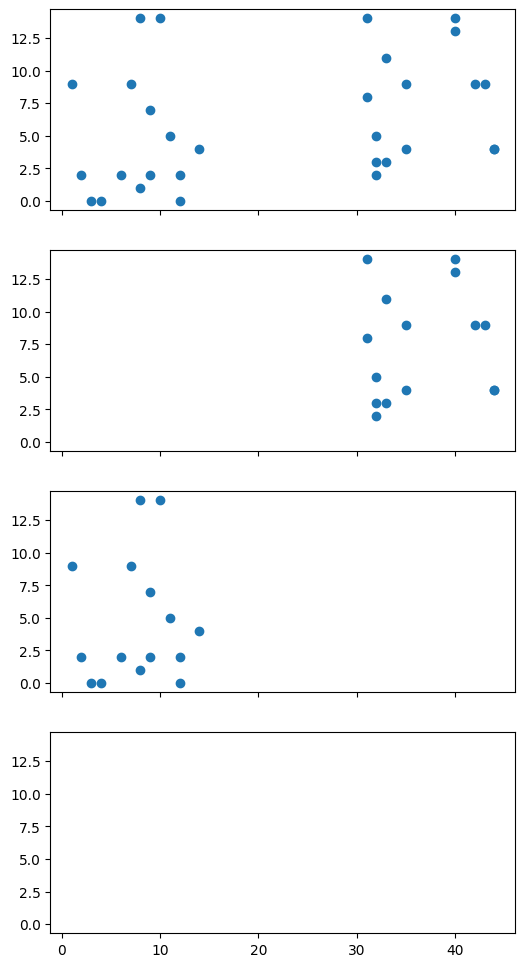

In [ ]:
n_plots = len(clusters) + 1
fig, axis = plt.subplots(n_plots, 1, sharex=True, sharey=True, figsize=(6, n_plots * 3))
x = X_train[:, 0]
y = X_train[:, 1]
axis[0].scatter(x, y)
for i, cluster in enumerate(clusters):
    x = X_train[cluster, 0]
    y = X_train[cluster, 1]
    axis[i+1].scatter(x, y)
plt.show()

In [ ]:
ds_agent.debugging_history

[{'u': 7,
  'v': 8,
  'action': 'merge_the_singletons',
  'u_nodes': [7],
  'v_nodes': [8],
  'cluster_nodes': [7, 8],
  'size': 2,
  'cluster_id': 7,
  'final_id': 7},
 {'u': 5,
  'v': 7,
  'action': 'absorb',
  'u_nodes': [7, 8],
  'v_nodes': [5],
  'cluster_nodes': [7, 8, 5],
  'size': 3,
  'cluster_id': 7,
  'final_id': 7},
 {'u': 4,
  'v': 5,
  'action': 'absorb',
  'u_nodes': [7, 8, 5],
  'v_nodes': [4],
  'cluster_nodes': [7, 8, 5, 4],
  'size': 4,
  'cluster_id': 7,
  'final_id': 7},
 {'u': 8,
  'v': 13,
  'action': 'absorb',
  'u_nodes': [7, 8, 5, 4],
  'v_nodes': [13],
  'cluster_nodes': [7, 8, 5, 4, 13],
  'size': 5,
  'cluster_id': 7,
  'final_id': 7},
 {'u': 16,
  'v': 17,
  'action': 'merge_the_singletons',
  'u_nodes': [16],
  'v_nodes': [17],
  'cluster_nodes': [16, 17],
  'size': 2,
  'cluster_id': 16,
  'final_id': 16},
 {'u': 16,
  'v': 18,
  'action': 'absorb',
  'u_nodes': [16, 17],
  'v_nodes': [18],
  'cluster_nodes': [16, 17, 18],
  'size': 3,
  'cluster_id': 16

# * OLD

In [ ]:
# #selected_points = [2, 3, 1, 0, 4]
# selected_points = None
# if selected_points:
#     x = X_train[selected_points, 0]
#     y = X_train[selected_points, 1]
# else:
#     x = X_train[:, 0]
#     y = X_train[:, 1]
# plt.scatter(x, y)
# # plt.xlim(0, m)
# # plt.ylim(0, m)
# plt.show()

In [ ]:
mst_edges

[(8, 9, 1.0),
 (7, 9, 1.0),
 (6, 7, 1.0),
 (2, 3, 1.0),
 (1, 2, 1.0),
 (0, 2, 1.5),
 (3, 4, 1.5),
 (5, 7, 2.0),
 (1, 6, 7.0)]

In [ ]:
X_train

array([[1. , 1. ],
       [1. , 2. ],
       [1. , 2.5],
       [1. , 3. ],
       [1. , 4. ],
       [8. , 1. ],
       [8. , 2. ],
       [8. , 3. ],
       [8. , 3.5],
       [8. , 4. ]])

## ** code

In [ ]:
class MyHDBScan:
    def __init__(
            self,
            cpu_gpu_device,
            number_of_nearest_neighbors=5):
        self.cpu_gpu_device = cpu_gpu_device
        # number of nearest neighbors
        self.k = number_of_nearest_neighbors

    def mutual_reachability_distance(self, X):
        """
        Compute the mutual reachability distance matrix using PyTorch and CUDA.
        """
        X = torch.tensor(X, dtype=torch.float32, device='cuda')  # Move data to GPU
        pairwise_dist = torch.cdist(X, X)  # Compute pairwise Euclidean distances
        knn_distances, _ = torch.topk(pairwise_dist, self.k + 1, largest=False)  # k-NN distances
        core_distances = knn_distances[:, -1].unsqueeze(1)  # Core distance is k-th neighbor

        # Compute mutual reachability distance
        mutual_dist_matrix = torch.max(pairwise_dist, core_distances)
        self.mutual_dist_matrix = torch.max(mutual_dist_matrix, core_distances.T)

    def minimum_spanning_tree(self):
        """
        Compute the Minimum Spanning Tree using Kruskal’s algorithm in PyTorch.
        """
        n = self.mutual_dist_matrix.shape[0]
        triu_indices = torch.triu_indices(n, n, 1, device=self.cpu_gpu_device)  # Get upper-triangle indices
        edge_weights = self.mutual_dist_matrix[triu_indices[0], triu_indices[1]]  # Extract edge weights
        sorted_indices = torch.argsort(edge_weights)  # Sort edges by weight

        parent = torch.arange(n, device=self.cpu_gpu_device)  # Union-Find structure

        def find(x):
            while parent[x] != x:
                x = parent[x]
            return x

        self.mst_edges = []
        for idx in sorted_indices:
            u, v = triu_indices[:, idx]
            root_u, root_v = find(u), find(v)

            if root_u != root_v:  # No cycle condition
                self.mst_edges.append((u.item(), v.item(), edge_weights[idx].item()))
                parent[root_v] = root_u

                if len(self.mst_edges) == n - 1:
                    break


In [ ]:
def mutual_reachability_distance(X, k=5):
    """
    Compute the mutual reachability distance matrix using PyTorch and CUDA.
    """
    X = torch.tensor(X, dtype=torch.float32, device='cuda')  # Move data to GPU
    pairwise_dist = torch.cdist(X, X)  # Compute pairwise Euclidean distances
    knn_distances, _ = torch.topk(pairwise_dist, k + 1, largest=False)  # k-NN distances
    core_distances = knn_distances[:, -1].unsqueeze(1)  # Core distance is k-th neighbor

    # Compute mutual reachability distance
    mutual_dist = torch.max(pairwise_dist, core_distances)
    mutual_dist = torch.max(mutual_dist, core_distances.T)

    return mutual_dist


In [ ]:
def minimum_spanning_tree(dist_matrix):
    """
    Compute the Minimum Spanning Tree using Kruskal’s algorithm in PyTorch.
    """
    n = dist_matrix.shape[0]
    triu_indices = torch.triu_indices(n, n, 1, device='cuda')  # Get upper-triangle indices
    edge_weights = dist_matrix[triu_indices[0], triu_indices[1]]  # Extract edge weights
    sorted_indices = torch.argsort(edge_weights)  # Sort edges by weight

    parent = torch.arange(n, device='cuda')  # Union-Find structure

    def find(x):
        while parent[x] != x:
            x = parent[x]
        return x

    mst_edges = []
    for idx in sorted_indices:
        u, v = triu_indices[:, idx]
        root_u, root_v = find(u), find(v)

        if root_u != root_v:  # No cycle condition
            mst_edges.append((u.item(), v.item(), edge_weights[idx].item()))
            parent[root_v] = root_u

        if len(mst_edges) == n - 1:
            break

    return mst_edges


In [ ]:
def hierarchical_clustering(mst_edges, min_cluster_size=10):
    """
    Perform bottom-up hierarchical clustering using the MST.
    """
    # Step 1: Initialize clusters
    clusters = {i: {i} for i in range(len(mst_edges) + 1)}

    # Step 2: Merge all nodes into one large cluster
    for u, v, _ in mst_edges:
        clusters[u].update(clusters[v])
        clusters[v] = clusters[u]

    # Step 3: Remove the heaviest edges step by step
    for u, v, weight in reversed(mst_edges):  # Start from largest weight
        # Remove connection
        clusters[u].remove(v)
        clusters[v].remove(u)

        # Extract unique clusters
        unique_clusters = set(map(tuple, clusters.values()))

        # Keep only valid clusters
        valid_clusters = [c for c in unique_clusters if len(c) >= min_cluster_size]

        # Stop if further splitting would make invalid clusters
        if len(valid_clusters) == len(unique_clusters):
            break

    # Step 4: Convert clusters to sets
    final_clusters = [set(c) for c in valid_clusters]

    return final_clusters


In [ ]:
def extract_clusters(clusters):
    """
    Convert hierarchical clusters into final labeled clusters.
    """
    cluster_labels = torch.full((len(clusters),), -1, dtype=torch.int, device='cuda')  # Default label -1 (noise)
    cluster_id = 0
    for cluster in clusters.values():
        for idx in cluster:
            cluster_labels[idx] = cluster_id
        cluster_id += 1
    return cluster_labels


In [ ]:
# Generate synthetic dataset
import numpy as np
X_train = np.random.rand(1000, 2)  # 1000 points in 2D

# Run HDBSCAN on GPU
dist_matrix = mutual_reachability_distance(X_train, k=5)
mst_edges = minimum_spanning_tree(dist_matrix)
clusters = hierarchical_clustering(mst_edges, min_cluster_size=10)
cluster_labels = extract_clusters(clusters)

# Transfer cluster labels back to CPU
cluster_labels = cluster_labels.cpu().numpy()

print("Cluster assignments:", np.unique(cluster_labels))



## ** clculatinos

In [ ]:
# Generate synthetic dataset
n_points, max_value = 30, 15
X_train = np.random.randint(max_value, size=(n_points, 2))  # points in 2D
X_train.shape

(30, 2)

In [ ]:
#np.random.seed(seed)
n_clusters = 2
points_per_cluster = n_points // n_clusters
remainder = n_points % n_clusters

X_train = []
for i in range(n_clusters):
    # Random cluster center
    center = np.random.uniform(-10, 10, size=2)
    # Random spread (standard deviation)
    sigma = np.random.uniform(0.5, 2.0)
    # Number of points in this cluster
    n = points_per_cluster + (1 if i < remainder else 0)
    # Generate points around center with Gaussian noise
    cluster_points = np.random.normal(loc=center, scale=sigma, size=(n, 2))
    X.append(cluster_points)

# Concatenate all clusters
X_train = np.vstack(X_train)

In [ ]:
data = pd.read_csv('data_clust_test.csv')
X_train = data[['x', 'y']].values
n_points = X_train.shape[0]
X_train.shape

(336, 2)

In [ ]:
clusterer = MyHDBScan(
    min_cluster_size=3,
    number_of_nearest_neighbors=3
)

In [ ]:
mst_edges = clusterer.get_mst_edges(X_train)
#mst_edges

## ** MST

In [ ]:
k = 3
min_cluster_size=4

In [ ]:
# Generate synthetic dataset
X_train = np.random.randint(10, size=(10, 2))  # 1000 points in 2D
X_train

array([[7, 0],
       [6, 4],
       [5, 2],
       [8, 0],
       [2, 4],
       [9, 0],
       [9, 7],
       [2, 4],
       [0, 6],
       [7, 7]], dtype=int32)

In [ ]:
X = torch.tensor(X_train, dtype=torch.float32, device='cpu')  # Move data to GPU
pairwise_dist = torch.cdist(X, X)  # Compute pairwise Euclidean distances
pairwise_dist

tensor([[0.0000, 1.0000, 1.5000, 2.0000, 3.0000, 7.0000, 7.0711, 7.2801, 7.4330,
         7.6158],
        [1.0000, 0.0000, 0.5000, 1.0000, 2.0000, 7.0711, 7.0000, 7.0711, 7.1589,
         7.2801],
        [1.5000, 0.5000, 0.0000, 0.5000, 1.5000, 7.1589, 7.0178, 7.0178, 7.0711,
         7.1589],
        [2.0000, 1.0000, 0.5000, 0.0000, 1.0000, 7.2801, 7.0711, 7.0000, 7.0178,
         7.0711],
        [3.0000, 2.0000, 1.5000, 1.0000, 0.0000, 7.6158, 7.2801, 7.0711, 7.0178,
         7.0000],
        [7.0000, 7.0711, 7.1589, 7.2801, 7.6158, 0.0000, 1.0000, 2.0000, 2.5000,
         3.0000],
        [7.0711, 7.0000, 7.0178, 7.0711, 7.2801, 1.0000, 0.0000, 1.0000, 1.5000,
         2.0000],
        [7.2801, 7.0711, 7.0178, 7.0000, 7.0711, 2.0000, 1.0000, 0.0000, 0.5000,
         1.0000],
        [7.4330, 7.1589, 7.0711, 7.0178, 7.0178, 2.5000, 1.5000, 0.5000, 0.0000,
         0.5000],
        [7.6158, 7.2801, 7.1589, 7.0711, 7.0000, 3.0000, 2.0000, 1.0000, 0.5000,
         0.0000]])

In [ ]:
knn_distances, _ = torch.topk(pairwise_dist, k + 1, largest=False)  # k-NN distances
knn_distances

tensor([[0.0000, 1.0000, 2.0000, 2.8284],
        [0.0000, 2.2361, 3.1623, 4.0000],
        [0.0000, 2.2361, 2.8284, 3.6056],
        [0.0000, 1.0000, 1.0000, 3.6056],
        [0.0000, 0.0000, 2.8284, 3.6056],
        [0.0000, 1.0000, 2.0000, 4.4721],
        [0.0000, 2.0000, 4.2426, 6.4031],
        [0.0000, 0.0000, 2.8284, 3.6056],
        [0.0000, 2.8284, 2.8284, 6.3246],
        [0.0000, 2.0000, 3.1623, 5.3852]], device='cuda:0')

In [ ]:
core_distances = knn_distances[:, -1].unsqueeze(1)  # Core distance is k-th neighbor
core_distances

tensor([[2.8284],
        [4.0000],
        [3.6056],
        [3.6056],
        [3.6056],
        [4.4721],
        [6.4031],
        [3.6056],
        [6.3246],
        [5.3852]], device='cuda:0')

In [ ]:
mutual_dist = torch.max(pairwise_dist, core_distances)
mutual_dist

tensor([[ 2.8284,  4.1231,  2.8284,  2.8284,  6.4031,  2.8284,  7.2801,  6.4031,
          9.2195,  7.0000],
        [ 4.1231,  4.0000,  4.0000,  4.4721,  4.0000,  5.0000,  4.2426,  4.0000,
          6.3246,  4.0000],
        [ 3.6056,  3.6056,  3.6056,  3.6056,  3.6056,  4.4721,  6.4031,  3.6056,
          6.4031,  5.3852],
        [ 3.6056,  4.4721,  3.6056,  3.6056,  7.2111,  3.6056,  7.0711,  7.2111,
         10.0000,  7.0711],
        [ 6.4031,  4.0000,  3.6056,  7.2111,  3.6056,  8.0623,  7.6158,  3.6056,
          3.6056,  5.8310],
        [ 4.4721,  5.0000,  4.4721,  4.4721,  8.0623,  4.4721,  7.0000,  8.0623,
         10.8167,  7.2801],
        [ 7.2801,  6.4031,  6.4031,  7.0711,  7.6158,  7.0000,  6.4031,  7.6158,
          9.0554,  6.4031],
        [ 6.4031,  4.0000,  3.6056,  7.2111,  3.6056,  8.0623,  7.6158,  3.6056,
          3.6056,  5.8310],
        [ 9.2195,  6.3246,  6.4031, 10.0000,  6.3246, 10.8167,  9.0554,  6.3246,
          6.3246,  7.0711],
        [ 7.0000,  

In [ ]:
# Compute mutual reachability distance
dist_matrix = torch.max(mutual_dist, core_distances.T)
dist_matrix

tensor([[ 2.8284,  4.1231,  3.6056,  3.6056,  6.4031,  4.4721,  7.2801,  6.4031,
          9.2195,  7.0000],
        [ 4.1231,  4.0000,  4.0000,  4.4721,  4.0000,  5.0000,  6.4031,  4.0000,
          6.3246,  5.3852],
        [ 3.6056,  4.0000,  3.6056,  3.6056,  3.6056,  4.4721,  6.4031,  3.6056,
          6.4031,  5.3852],
        [ 3.6056,  4.4721,  3.6056,  3.6056,  7.2111,  4.4721,  7.0711,  7.2111,
         10.0000,  7.0711],
        [ 6.4031,  4.0000,  3.6056,  7.2111,  3.6056,  8.0623,  7.6158,  3.6056,
          6.3246,  5.8310],
        [ 4.4721,  5.0000,  4.4721,  4.4721,  8.0623,  4.4721,  7.0000,  8.0623,
         10.8167,  7.2801],
        [ 7.2801,  6.4031,  6.4031,  7.0711,  7.6158,  7.0000,  6.4031,  7.6158,
          9.0554,  6.4031],
        [ 6.4031,  4.0000,  3.6056,  7.2111,  3.6056,  8.0623,  7.6158,  3.6056,
          6.3246,  5.8310],
        [ 9.2195,  6.3246,  6.4031, 10.0000,  6.3246, 10.8167,  9.0554,  6.3246,
          6.3246,  7.0711],
        [ 7.0000,  

In [ ]:
"""
Compute the Minimum Spanning Tree using Kruskal’s algorithm in PyTorch.
"""
n = dist_matrix.shape[0]
triu_indices = torch.triu_indices(n, n, 1, device='cuda')  # Get upper-triangle indices
triu_indices

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
         3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 8],
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9,
         4, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 6, 7, 8, 9, 7, 8, 9, 8, 9, 9]],
       device='cuda:0')

In [ ]:
edge_weights = dist_matrix[triu_indices[0], triu_indices[1]]  # Extract edge weights
sorted_indices = torch.argsort(edge_weights)  # Sort edges by weight
edge_weights

tensor([ 4.1231,  3.6056,  3.6056,  6.4031,  4.4721,  7.2801,  6.4031,  9.2195,
         7.0000,  4.0000,  4.4721,  4.0000,  5.0000,  6.4031,  4.0000,  6.3246,
         5.3852,  3.6056,  3.6056,  4.4721,  6.4031,  3.6056,  6.4031,  5.3852,
         7.2111,  4.4721,  7.0711,  7.2111, 10.0000,  7.0711,  8.0623,  7.6158,
         3.6056,  6.3246,  5.8310,  7.0000,  8.0623, 10.8167,  7.2801,  7.6158,
         9.0554,  6.4031,  6.3246,  5.8310,  7.0711], device='cuda:0')

In [ ]:
parent = torch.arange(n, device='cuda')  # Union-Find structure
parent

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')

In [ ]:
def find(x):
    while parent[x] != x:
        x = parent[x]
    return x

mst_edges = []
for idx in sorted_indices:
    u, v = triu_indices[:, idx]
    root_u, root_v = find(u), find(v)

    if root_u != root_v:  # No cycle condition
        mst_edges.append((u.item(), v.item(), edge_weights[idx].item()))
        parent[root_v] = root_u

        if len(mst_edges) == n - 1:
            break

print(parent)
mst_edges

tensor([1, 1, 0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')


[(0, 2, 3.605551242828369),
 (0, 3, 3.605551242828369),
 (2, 4, 3.605551242828369),
 (2, 7, 3.605551242828369),
 (1, 2, 4.0),
 (0, 5, 4.4721360206604),
 (1, 9, 5.385164737701416),
 (1, 8, 6.324555397033691),
 (1, 6, 6.4031243324279785)]

## ** Hierarchical 1

In [ ]:
# Initialize each node as its own cluster
parent = {i: {i} for i in range(len(mst_edges) + 1)}

# Function to find the root of a cluster
def find(node):
    if parent[node] != node:
        parent[node] = find(parent[node])  # Path compression
    return parent[node]

# Function to merge two clusters
def union(node1, node2):
    root1 = find(node1)
    root2 = find(node2)
    if root1 != root2:
        parent[root2] = root1  # Merge clusters

# Iterate through sorted edges and merge clusters
for edge in mst_edges:
    node1, node2, weight = edge
    if find(node1) != find(node2):  # If nodes are in different clusters
        print(f"Merging clusters: {node1} and {node2} (weight: {weight})")
        union(node1, node2)
    break

Merging clusters: 0 and 2 (weight: 3.605551242828369)


In [ ]:
parent

{0: 0, 2: 0, 3: 3, 4: 4, 7: 7, 1: 1, 5: 5, 9: 9, 8: 8, 6: 6}

In [ ]:
"""
Perform bottom-up hierarchical clustering using the MST.
"""
# Step 1: Initialize clusters
clusters = {i: {i} for i in range(len(mst_edges) + 1)}

# Step 2: Merge all nodes into one large cluster
for u, v, _ in mst_edges:
    clusters[u].update(clusters[v])
    clusters[v] = clusters[u]
clusters

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}

In [ ]:
# Step 3: Remove the heaviest edges step by step
for u, v, weight in reversed(mst_edges):  # Start from largest weight
    # Remove connection
    clusters[u].discard(v)
    clusters[v].discard(u)

    # Extract unique clusters
    unique_clusters = set(map(tuple, clusters.values()))

    # Keep only valid clusters
    valid_clusters = [c for c in unique_clusters if len(c) >= min_cluster_size]

    # Stop if further splitting would make invalid clusters
    if len(valid_clusters) == len(unique_clusters):
        break

# Step 4: Convert clusters to sets
final_clusters = [set(c) for c in valid_clusters]

In [ ]:
clusters

{0: {0, 2, 3, 4, 5, 7},
 1: {0, 2, 3, 4, 7, 8, 9},
 2: {0, 2, 3, 4, 7, 8, 9},
 3: {0, 2, 3, 4, 5, 7},
 4: {0, 2, 3, 4, 5, 7},
 5: {0, 2, 3, 4, 5, 7},
 6: {0, 2, 3, 4, 7, 8, 9},
 7: {0, 2, 3, 4, 5, 7},
 8: {0, 2, 3, 4, 7, 8, 9},
 9: {0, 2, 3, 4, 7, 8, 9}}

In [ ]:
clusters.values()

dict_values([{0, 2, 3, 4, 5, 7}, {0, 2, 3, 4, 7, 8, 9}, {0, 2, 3, 4, 7, 8, 9}, {0, 2, 3, 4, 5, 7}, {0, 2, 3, 4, 5, 7}, {0, 2, 3, 4, 5, 7}, {0, 2, 3, 4, 7, 8, 9}, {0, 2, 3, 4, 5, 7}, {0, 2, 3, 4, 7, 8, 9}, {0, 2, 3, 4, 7, 8, 9}])

In [ ]:
unique_clusters

{(0, 2, 3, 4, 5, 7), (0, 2, 3, 4, 7, 8, 9)}

In [ ]:
valid_clusters

[(0, 2, 3, 4, 5, 7), (0, 2, 3, 4, 7, 8, 9)]

## ** H ver 2

In [ ]:
class MyHDBScan:
    def __init__(
            self,
            min_cluster_size,
            number_of_nearest_neighbors=None,
            cpu_gpu_device = 'cpu',
        ):
        # minimum cluster size
        self.min_cluster_size = min_cluster_size
        # number of nearest neighbors
        self.k = number_of_nearest_neighbors or min_cluster_size
        self.cpu_gpu_device = cpu_gpu_device

    def calculate_mutual_reachability_distances(self, X):
        """
        Compute the mutual reachability distance matrix using PyTorch and CUDA.
        """
        X = torch.tensor(X, dtype=torch.float32, device=self.cpu_gpu_device)  # Move data to device
        pairwise_dist = torch.cdist(X, X)  # Compute pairwise Euclidean distances
        knn_distances, _ = torch.topk(pairwise_dist, self.k + 1, largest=False)  # k-NN distances
        core_distances = knn_distances[:, -1].unsqueeze(1)  # Core distance is k-th neighbor

        # Compute mutual reachability distance
        mutual_dist_matrix = torch.max(pairwise_dist, core_distances)
        self.mutual_dist_matrix = torch.max(mutual_dist_matrix, core_distances.T)

    def calculate_minimum_spanning_tree(self):
        """
        Compute the Minimum Spanning Tree using Kruskal’s algorithm in PyTorch.
        """
        n = self.mutual_dist_matrix.shape[0]
        triu_indices = torch.triu_indices(n, n, 1, device=self.cpu_gpu_device)  # Get upper-triangle indices
        edge_weights = self.mutual_dist_matrix[triu_indices[0], triu_indices[1]]  # Extract edge weights
        sorted_indices = torch.argsort(edge_weights)  # Sort edges by weight

        parent = torch.arange(n, device=self.cpu_gpu_device)  # Union-Find structure

        def find(x):
            while parent[x] != x:
                x = parent[x]
            return x

        self.mst_edges = []
        for idx in sorted_indices:
            u, v = triu_indices[:, idx]
            root_u, root_v = find(u), find(v)

            if root_u != root_v:  # No cycle condition
                self.mst_edges.append((u.item(), v.item(), edge_weights[idx].item()))
                parent[root_v] = root_u

                if len(self.mst_edges) == n - 1:
                    break

    def get_mst_edges(self, X):
        self.calculate_mutual_reachability_distances(X)
        self.calculate_minimum_spanning_tree()
        return self.mst_edges

In [ ]:
class DendrogramNode:
    def __init__(self, left=None, right=None, merge_distance=None, points=None):
        # left and right are children nodes
        self.left = left
        self.right = right
        # merge_distance is the MST edge weight at which this merge occurs
        self.merge_distance = merge_distance
        # points holds the indices of the points in this cluster
        self.points = points if points is not None else []

    def __repr__(self):
        return f"merge_distance: {self.merge_distance}, points: {self.points}"

In [ ]:
# A simple union-find (disjoint-set) implementation for merging clusters.
class DisjointSet:
    def __init__(self, elems):
        self.parent = {x: x for x in elems}
        self.size = {x: 1 for x in elems}
        # Each point starts as a separate dendrogram node (leaf)
        self.cluster_nodes = {x: DendrogramNode(points=[x]) for x in elems}

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, rep_u, rep_v):
        if self.size[rep_u] < self.size[rep_v]:
            self.parent[rep_u] = rep_v
            self.size[rep_v] += self.size[rep_u]
            return rep_v
        else:
            self.parent[rep_v] = rep_u
            self.size[rep_u] += self.size[rep_v]
            return rep_u

    def build_dendrogram(self, mst_edges):
        # Sort the MST edges by increasing weight (or increasing lambda if using 1/weight)
        #mst_edges = sorted(mst_edges, key=lambda edge: edge[2])

        # Process each edge to merge clusters
        for u, v, weight in mst_edges:
            rep_u = self.find(u)
            rep_v = self.find(v)
            if rep_u != rep_v:
                # Create a new dendrogram node that represents the merge of two clusters
                merged_points = self.cluster_nodes[rep_u].points + self.cluster_nodes[rep_v].points
                new_node = DendrogramNode(left=self.cluster_nodes[rep_u],
                                        right=self.cluster_nodes[rep_v],
                                        merge_distance=weight,
                                        points=merged_points)
                # Merge clusters in the union-find structure
                new_rep = self.union(rep_u, rep_v)  # new representative after union
                self.cluster_nodes[new_rep] = new_node

        # At the end, there should be a single cluster containing all points.
        # We return the dendrogram root.
        root = self.cluster_nodes[self.find(0)]
        return root

In [ ]:
def compute_stability(node, parent_merge_distance):
    """
    Compute the stability of a node as:
      stability = (parent_merge_distance - node_birth) * (number of points)

    For leaf nodes (which have no merge_distance), assume node_birth = 0.
    """
    node_birth = node.merge_distance if node.merge_distance is not None else 0
    stability = len(node.points) * (parent_merge_distance - node_birth)
    return stability


def extract_stable_clusters(node, min_cluster_size, parent_merge_distance=float('inf')):
    """
    Recursively extract stable clusters from the dendrogram.

    Args:
      node: the current dendrogram node
      min_cluster_size: clusters with fewer than this many points are discarded
      parent_merge_distance: the merge distance at which the parent node was created.
                             This acts as the "death" level for the current node.

    Returns:
      A list of tuples (cluster_node, stability) for the selected clusters.
    """
    # Discard clusters smaller than min_cluster_size
    if len(node.points) < min_cluster_size:
        return []

    # If the node is a leaf (no children), it is a candidate cluster.
    if node.left is None and node.right is None:
        return [(node, compute_stability(node, parent_merge_distance))]

    # Recursively extract clusters from both children.
    left_clusters = extract_stable_clusters(node.left, min_cluster_size, node.merge_distance)
    right_clusters = extract_stable_clusters(node.right, min_cluster_size, node.merge_distance)
    children_clusters = left_clusters + right_clusters
    children_stability = sum(stab for _, stab in children_clusters)

    # Compute stability if we consider the current node as a cluster.
    current_stability = compute_stability(node, parent_merge_distance)

    # Choose the configuration (current node vs. children) with greater total stability.
    if current_stability >= children_stability:
        return [(node, current_stability)]
    else:
        return children_clusters


In [ ]:
# Define the minimum cluster size.
min_cluster_size = 2

# Extract clusters from the dendrogram.
clusters = extract_stable_clusters(root, min_cluster_size)
print("Extracted clusters:")
for cluster, stability in clusters:
    print(f"Cluster with points {cluster.points}, stability: {stability}")

Extracted clusters:
Cluster with points [9, 0, 13, 3, 22, 1, 15, 17, 6, 21, 7, 12, 28, 10, 23, 2, 11, 16, 27, 5, 14, 29, 4, 19, 8, 20, 18, 26, 25, 24], stability: inf


## ** ChatGPT o1

In [ ]:
# BSD 3-Clause License
#
# Copyright (c) 2015, Derek Greene
# Copyright (c) 2015, Lars Buitinck
# All rights reserved.
#
# ... [License text truncated for brevity, see full license in HDBSCAN repo] ...

import numpy as np
from collections import defaultdict

class CondensedTree(object):
    """
    CondensedTree represents the condensed hierarchy produced by HDBSCAN.
    It provides methods to compute cluster stability ('excess of mass') and
    select the final clusters.
    """

    def __init__(self, parent, child, lambda_val, child_size, n_points, point_label):
        """
        Create a condensed tree representation from arrays of parent,
        child, lambda_val, child_size, etc.
        ...
        """
        self._parent = parent
        self._child = child
        self._lambda = lambda_val
        self._child_size = child_size
        self._n_points = n_points
        self._point_label = point_label
        self._max_lmbd = np.max(self._lambda)
        self._min_lmbd = np.min(self._lambda)
        # (Some lines omitted for brevity)

        self._num_nodes = len(self._parent)
        # This will be filled by compute_stability():
        self._stability = None
        # Used for final cluster selection:
        self._clusters = None
        self._cluster_tree = None

    def compute_stability(self, cluster_selection_epsilon=0.0):
        """
        Compute the stability (excess of mass) for each cluster in the
        condensed tree. This is essentially the integral of cluster size
        over the lambda range at which it exists, adjusting for epsilon
        if cluster_selection_epsilon > 0.0.

        Parameters
        ----------
        cluster_selection_epsilon : float (default=0.0)
            A distance threshold. Clusters must persist over an additional
            distance of epsilon to be considered separate. In practice,
            we scale lambda by (1 + cluster_selection_epsilon) in merges.
        """
        if self._stability is not None:
            return

        # Some helper structures
        stability = np.zeros(self._num_nodes, dtype=float)
        children = defaultdict(list)
        for i in range(self._num_nodes):
            p = self._parent[i]
            if p >= 0:
                children[p].append(i)

        # Sort child nodes of each parent by ascending lambda
        for p in children:
            c_list = children[p]
            c_list.sort(key=lambda x: self._lambda[x])

        # Depth-first stack approach to accumulate stability
        stack = []
        root_nodes = [i for i in range(self._num_nodes) if self._parent[i] < 0]
        for r in root_nodes:
            stack.append(r)

        while stack:
            node = stack.pop()
            # We have to integrate the child cluster sizes from the parent's lambda
            # to the child's lambda to compute the area under size curve
            node_children = children[node]
            prev_lambda = self._lambda[node] if node < self._n_points else 0.0
            if node < self._n_points:
                # Leaves represent single points with lambdaVal as the level
                pass

            for c in node_children:
                # The cluster below child c persists from (prev_lambda) up to self._lambda[c]
                # so the stability contributed is child_size[c] * (self._lambda[c] - prev_lambda)
                delta_lambda = (self._lambda[c] - prev_lambda) * (1.0 + cluster_selection_epsilon)
                if delta_lambda < 0:
                    delta_lambda = 0
                stability[c] += self._child_size[c] * delta_lambda
                stack.append(c)
                prev_lambda = self._lambda[c]

            # If no children, it's a leaf - but leaves can still exist until top
            # we don't close them out until they get merged or are root

        self._stability = stability

    def select_clusters(self, cluster_selection_epsilon=0.0, min_cluster_size=None):
        """
        Select clusters from the condensed tree by maximizing the
        stability (excess of mass). Perform an epsilon correction
        if cluster_selection_epsilon > 0.0.

        Returns a dictionary: {cluster_label: [list_of_points]}.
        """
        # Ensure stability is computed
        self.compute_stability(cluster_selection_epsilon=cluster_selection_epsilon)

        # We'll store final cluster labels in _clusters
        # This is a dict: node_id -> cluster_id
        self._clusters = {}
        cluster_id = 0

        # We'll do a DFS from root nodes, deciding if we take each subtree
        children = defaultdict(list)
        for i in range(self._num_nodes):
            p = self._parent[i]
            if p >= 0:
                children[p].append(i)

        # Sort children by descending stability, or we might replicate
        # HDBSCAN's approach more precisely
        for c_list in children.values():
            c_list.sort(key=lambda x: self._stability[x], reverse=True)

        root_nodes = [i for i in range(self._num_nodes) if self._parent[i] < 0]
        stack = []
        for r in root_nodes:
            stack.append(r)

        while stack:
            node = stack.pop()
            # If min_cluster_size is set, we can skip nodes whose child_size < min_cluster_size
            if min_cluster_size is not None and self._child_size[node] < min_cluster_size:
                # Recur on children but do not mark node as a cluster
                for c in children[node]:
                    stack.append(c)
                continue

            # If the node's stability is high enough to be considered a cluster on its own
            # we can label it here. Alternatively, we can compare child stabilities to see
            # if we should keep splitting.
            # In the official HDBSCAN, there's a more detailed rule set for splitting vs. keeping.
            # We'll do a simplified approach:
            # If none of the child subtrees has higher stability, we consider 'node' a cluster.
            c_stabilities = [self._stability[ch] for ch in children[node]]
            if len(c_stabilities) == 0 or max(c_stabilities) < self._stability[node]:
                # Mark the node as a cluster
                self._clusters[node] = cluster_id
                cluster_id += 1
            else:
                # It's better to recurse down to children
                for c in children[node]:
                    stack.append(c)

        # Next, assign each leaf data point to the cluster of its ancestor
        # or mark as noise if no ancestor is a cluster
        point_to_cluster = np.full(self._n_points, -1, dtype=int)
        for leaf_id in range(self._n_points):
            node = leaf_id
            c_label = -1
            while node != -1:
                if node in self._clusters:
                    c_label = self._clusters[node]
                    break
                p = self._parent[node]
                node = p if p >= 0 else -1
            point_to_cluster[leaf_id] = c_label

        return point_to_cluster

    # ... More methods omitted for brevity ...


In [ ]:
# A simple union-find (disjoint-set) implementation for merging clusters.
class DisjointSet:
    def __init__(self, elems):
        self.parent = {x: x for x in elems}
        self.clusters_size = {x: 1 for x in elems}
        self.single_linkage_tree = []
        n = len(elems)
        # Create a structure "cluster_info" to hold birth_distance, death_distance, size, parent
        self.clusters = [
            dict(birth=0.0, death=float('inf'), size=1, parent=None)
            for _ in range(2*n - 1)
        ]

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, rep_u, rep_v):
        if self.clusters_size[rep_u] < self.clusters_size[rep_v]:
            self.parent[rep_u] = rep_v
            self.clusters_size[rep_v] += self.clusters_size[rep_u]
            return rep_v
        else:
            self.parent[rep_v] = rep_u
            self.clusters_size[rep_u] += self.clusters_size[rep_v]
            return rep_u

    def build_hierarchy(self, mst_edges):
        # Sort the MST edges by increasing weight (or increasing lambda if using 1/weight)
        #mst_edges = sorted(mst_edges, key=lambda edge: edge[2])

        # Process each edge to merge clusters
        current_label = n
        for u, v, distance in mst_edges:
            rep_u = self.find(u)
            rep_v = self.find(v)
            if rep_u != rep_v:
                new_size = self.clusters_size[rep_u] + self.clusters_size[rep_v]
                # The new cluster is "born" at 'dist'
                self.clusters[current_label] = {
                    'birth': distance,
                    'death': float('inf'),    # we'll fill in if it merges later
                    'size': new_size,
                    'parent': None
                }
                # node1 merges into new_cluster at distance=dist
                self.clusters[rep_u]['death'] = distance
                self.clusters[rep_u]['parent'] = current_label

                # node2 merges into new_cluster as well
                self.clusters[rep_v]['death'] = distance
                self.clusters[rep_v]['parent'] = current_label

                self.single_linkage_tree.append([rep_u, rep_v, distance])
                current_label += 1
                # Merge clusters in the union-find structure
                new_rep = self.union(rep_u, rep_v)  # new representative after union

In [ ]:
n = number_of_data_points
linkage = your (n-1) x 3 array of merges, sorted by ascending distance

# We'll store info for 2n-1 possible "nodes":
#  - 0..(n-1): the original data points (clusters of size=1)
#  - n..(2n-2): internal clusters formed at each merge step
# (SciPy uses exactly this scheme)

# Create a structure "cluster_info" to hold birth_distance, death_distance, size, parent
cluster_info = [ dict(birth=0.0, death=float('inf'), size=1, parent=None)
                 for _ in range(2*n - 1) ]

# For the n original points, birth_distance=0, size=1 by default
# They won't have a parent or a meaningful 'death' yet.

current_cluster_label = n  # internal cluster IDs start at n

for (node1, node2, dist) in linkage:
    # cluster1 = the info structure for node1
    # cluster2 = the info structure for node2
    # new_cluster = the "merged" cluster with label = current_cluster_label

    size1 = cluster_info[node1]['size']
    size2 = cluster_info[node2]['size']
    new_size = size1 + size2

    # The new cluster is "born" at 'dist'
    cluster_info.append({
        'birth': dist,
        'death': float('inf'),    # we'll fill in if it merges later
        'size': new_size,
        'parent': None
    })

    # node1 merges into new_cluster at distance=dist
    cluster_info[node1]['death'] = dist
    cluster_info[node1]['parent'] = current_cluster_label

    # node2 merges into new_cluster as well
    cluster_info[node2]['death'] = dist
    cluster_info[node2]['parent'] = current_cluster_label

    # cluster_info for new_cluster is stored at "current_cluster_label"
    cluster_info[current_cluster_label] = {
        'birth': dist,
        'death': float('inf'),
        'size': new_size,
        'parent': None
    }

    # increment cluster label
    current_cluster_label += 1


## ** Grok

### *** original

In [ ]:
def build_hierarchy(self, mst_edges):
    """
    Build single linkage hierarchy from MST edges.
    """
    active_clusters = set(range(self.n_points))
    hierarchy = []  # [parent, child, lambda_val, size]
    self.cluster_id = self.n_points  # Unique IDs start after points

    for u, v, distance in mst_edges:
        lambda_val = 1 / distance
        root_u, root_v = self.find(u), self.find(v)

        if root_u != root_v:
            for root in (root_u, root_v):
                if root in active_clusters:
                    birth, _ = self.clusters_lambdas[root][-1]
                    self.clusters_lambdas[root][-1] = (birth, lambda_val)
                    active_clusters.remove(root)

            new_root = self.union(root_u, root_v)
            new_size = self.clusters_sizes[new_root]
            self.clusters_lambdas[new_root].append((lambda_val, float('inf')))
            active_clusters.add(new_root)

            # Record hierarchy: parent is new cluster, child is merged root
            hierarchy.append([self.cluster_id, root_u, lambda_val, self.clusters_sizes[root_u]])
            hierarchy.append([self.cluster_id, root_v, lambda_val, self.clusters_sizes[root_v]])
            self.cluster_id += 1

    # Finalize root
    assert len(active_clusters) == 1
    cl_id = active_clusters.pop()
    birth, death = self.clusters_lambdas[cl_id][-1]
    if death == float('inf'):
        self.clusters_lambdas[cl_id][-1] = (birth, 0)

    self.hierarchy = hierarchy

In [ ]:
def condense_tree(self, min_cluster_size):
    """
    Condense hierarchy into a tree of significant clusters.
    """
    condensed_tree = []  # [parent, child, lambda_val, child_size]
    node_sizes = {i: 1 for i in range(self.n_points)}  # Track sizes
    node_lambdas = {}  # Track lambda at which nodes split

    # Process hierarchy bottom-up
    for parent, child, lambda_val, size in self.hierarchy:
        node_lambdas[child] = lambda_val
        if parent not in node_sizes:
            node_sizes[parent] = 0
        node_sizes[parent] += size

        # If parent size >= min_cluster_size, add to condensed tree
        if node_sizes[parent] >= min_cluster_size:
            condensed_tree.append([parent, child, lambda_val, size])
        # If child was a cluster but now splits, record its death
        elif child >= self.n_points and child in node_sizes:
            condensed_tree.append([parent, child, lambda_val, node_sizes[child]])

    self.condensed_tree = condensed_tree
    return condensed_tree

In [ ]:
def define_clusters(self, condensed_tree, min_cluster_size):
    """
    Select clusters using Excess of Mass.
    """
    # Compute stability
    stability = {}
    cluster_sizes = {}
    for parent, child, lambda_val, child_size in condensed_tree:
        if parent not in stability:
            stability[parent] = 0
        if child >= self.n_points:  # Only clusters, not points
            stability[child] = stability.get(child, 0) + (lambda_val - self.clusters_lambdas[child][-1][1])
        cluster_sizes[parent] = cluster_sizes.get(parent, 0) + child_size
        cluster_sizes[child] = child_size

    # Build children mapping
    cluster_children = {}
    for parent, child, _, _ in condensed_tree:
        if parent not in cluster_children:
            cluster_children[parent] = []
        cluster_children[parent].append(child)

    selected_clusters = set()
    root = max(cluster_sizes.keys())  # Last cluster ID

    def evaluate_cluster(cid):
        children = cluster_children.get(cid, [])
        if not children or cluster_sizes[cid] < min_cluster_size:
            if cid in stability and cluster_sizes[cid] >= min_cluster_size:
                selected_clusters.add(cid)
                return stability.get(cid, 0)
            return 0

        my_stability = stability.get(cid, 0)
        children_stability = sum(evaluate_cluster(child) for child in children)

        if my_stability >= children_stability:
            selected_clusters.add(cid)
            return my_stability
        return children_stability

    evaluate_cluster(root)
    self.selected_clusters = selected_clusters
    return selected_clusters

### *** code

In [ ]:
class Cluster:
    def __init__(
            self,
            size,
            lambda_birth=None,
            lambda_death=None,
            children=[],
            nodes=[],
            persistence = 0,
            is_node = False
    ):
        self.size = size
        self.lambda_birth = lambda_birth
        self.lambda_death = lambda_death
        self.children = children
        self.nodes = nodes
        self.persistence = persistence
        self.is_node = is_node

class DisjointSet:
    def __init__(self, n_points, min_cluster_size):
        self.parents = list(range(n_points))
        # For Union-Find optimization (tree height)
        self.clusters_ranks = [0] * n_points
        # Track size of each cluster
        self.clusters_sizes = [1] * n_points

        self.n_points = n_points
        self.min_cluster_size = min_cluster_size

        # Initialize singletons clusters
        self.clusters = {}
        for i in range(self.n_points):
            self.clusters[i] = Cluster(
                size=1,
                nodes=[i],
                is_node=True
            )

    def find(self, u):
        if self.parents[u] != u:
            self.parents[u] = self.find(self.parents[u])  # Path compression
        return self.parents[u]

    def union(self, root_u, root_v):
        if self.clusters_ranks[root_u] < self.clusters_ranks[root_v]:
            root_u, root_v = root_v, root_u
        self.parents[root_v] = root_u
        # Update size
        self.clusters_sizes[root_u] += self.clusters_sizes[root_v]
        # Rank increases only if equal height
        if self.clusters_ranks[root_u] == self.clusters_ranks[root_v]:
            self.clusters_ranks[root_u] += 1
        return root_u

    def build_hierarchy(self, mst_edges):
        """
        Build hierarchy from MST
        Args:
            mst_edges: List of [(u, v, distance), ...] sorted by increasing distance
        """

        # Initialize trackers
        active_clusters = set(range(self.n_points))
        root_clusters_map = {i: i for i in range(self.n_points)}

        # Start assigning new IDs after original points
        cluster_id = self.n_points - 1
        # Process MST edges in order of increasing distance
        for u, v, distance in mst_edges:
            # increment cluster ID
            cluster_id += 1
            # Lambda = inverse of distance
            lambda_val = 1 / distance
            root_u, root_v = self.find(u), self.find(v)

            if root_u != root_v:
                children = []
                for root in (root_u, root_v):
                    active_clusters.discard(root)
                    # Update children
                    child_id = root_clusters_map[root]
                    children.append(child_id)
                    # update lambda_birth
                    child_cluster = self.clusters[child_id]
                    child_cluster.persistance = child_cluster.lambda_death - lambda_val


                # Merge clusters
                new_root = self.union(root_u, root_v)

                active_clusters.add(new_root)
                root_clusters_map[new_root] = cluster_id

                self.clusters[cluster_id] = Cluster(
                    size=self.clusters_sizes[new_root],
                    lambda_death=lambda_val,
                    children=children,
                )

        self.clusters[cluster_id].lambda_birth = 0

    def condense_and_compute_persistence(self):
        """
        Condense hierarchy and compute persistence for significant clusters.
        """
        self.condensed_tree = []
        self.persistence = {}
        # Track clusters already processed for persistence

        for event in self.merge_events:
            cluster_size = event['size']

            # Include in condensed tree if the new cluster is significant
            if cluster_size >= self.min_cluster_size:
                # Compute persistence only once per significant cluster
                cluster_id = event['cluster_id']
                # First birth when it becomes significant
                lambda_birth = event['lambda_birth']
                # Final death from clusters_lambdas
                root = event['root']
                lambda_death = self.clusters_lambdas[root][-1][1]
                self.persistence[cluster_id] = lambda_birth - lambda_death
                # add to condence tree
                self.condensed_tree.append(event)

    def select_clusters_eom(self):
        """
        Select clusters using Excess of Mass method.

        Returns:
            selected_clusters: Set of cluster IDs in the final clustering
        """
        selected_clusters = set()
        cluster_children = {}  # Map parent to children

        # Build parent-child relationships (reverse hierarchy)
        for event in self.condensed_tree:
            cluster_id = event['cluster_id']
            cluster_children[cluster_id] = [event['left'], event['right']]

        # Start from the root (last event's new_cluster)
        root = self.condensed_tree[-1]['cluster_id'] if self.condensed_tree else None
        if not root:
            return selected_clusters

        def evaluate_cluster(cl_id):
            children = cluster_children.get(cl_id, [])
            if not children:
                if cl_id in self.persistence:
                    selected_clusters.add(cl_id)
                    return self.persistence.get(cl_id, 0)
                return 0

            my_persistence = self.persistence.get(cl_id, 0)
            children_persistence = sum(evaluate_cluster(child) for child in children)
            if my_persistence >= children_persistence:
                selected_clusters.add(cl_id)
                return my_persistence
            return children_persistence  # Split into children

        evaluate_cluster(root)
        return selected_clusters

### *** how to use

In [ ]:
mst_edges

[(7, 22, 2.2360680103302),
 (9, 21, 2.2360680103302),
 (5, 12, 2.2360680103302),
 (5, 19, 2.2360680103302),
 (7, 15, 2.8284270763397217),
 (15, 24, 2.8284270763397217),
 (9, 14, 2.8284270763397217),
 (5, 26, 2.8284270763397217),
 (10, 19, 2.8284270763397217),
 (14, 22, 2.8284270763397217),
 (10, 14, 2.8284270763397217),
 (1, 12, 3.0),
 (17, 24, 3.1622776985168457),
 (6, 22, 3.1622776985168457),
 (7, 28, 3.605551242828369),
 (4, 25, 3.605551242828369),
 (4, 23, 3.605551242828369),
 (0, 12, 3.605551242828369),
 (4, 20, 3.605551242828369),
 (26, 29, 3.605551242828369),
 (18, 25, 4.0),
 (2, 28, 4.123105525970459),
 (25, 28, 4.123105525970459),
 (8, 20, 4.123105525970459),
 (12, 13, 4.4721360206604),
 (12, 27, 4.4721360206604),
 (16, 24, 4.4721360206604),
 (10, 11, 5.0),
 (3, 15, 5.0)]

In [ ]:
# Example usage
min_cluster_size = 3
ds = DisjointSet(n_points)
ds.build_hierarchy(mst_edges)

In [ ]:
# Print results for inspection
print("Merge Events:")
for event in ds.merge_events[-6:]:
    print(event)

Merge Events:
{'left': 155, 'right': 324, 'root': 155, 'cluster_id': 665, 'lambda_birth': 0.034374361161839354, 'size': 112}
{'left': 270, 'right': 155, 'root': 270, 'cluster_id': 666, 'lambda_birth': 0.034374361161839354, 'size': 213}
{'left': 28, 'right': 39, 'root': 28, 'cluster_id': 667, 'lambda_birth': 0.033364628369798, 'size': 121}
{'left': 270, 'right': 311, 'root': 270, 'cluster_id': 668, 'lambda_birth': 0.03199897659523096, 'size': 214}
{'left': 270, 'right': 321, 'root': 270, 'cluster_id': 669, 'lambda_birth': 0.026997461366948337, 'size': 215}
{'left': 270, 'right': 28, 'root': 270, 'cluster_id': 670, 'lambda_birth': 0.0204665847932488, 'size': 336}


In [ ]:
print("\nCluster Lambda Ranges:")
for cid, lambdas in ds.clusters_lambdas.items():
    # if ranges and ranges[0][0] != float('inf'):  # Filter out initial singleton ranges
    #     print(f"Cluster {cid}: {ranges}")
    # print(f"Cluster {cid}: {ranges}")
    if len(lambdas) > 1:  # Include clusters with defined death
        print(f"Cluster {cid}: {lambdas}")


Cluster Lambda Ranges:
Cluster 4: [(inf, 0.2773501006230469), (0.2773501006230469, 0.2773501006230469), (0.2773501006230469, 0.2773501006230469), (0.2773501006230469, 0.25), (0.25, 0.2425356308979332)]
Cluster 5: [(inf, 0.4472135889338759), (0.4472135889338759, 0.4472135889338759), (0.4472135889338759, 0.3535533966440824), (0.3535533966440824, 0.3535533966440824), (0.3535533966440824, 0.3535533966440824)]
Cluster 7: [(inf, 0.4472135889338759), (0.4472135889338759, 0.3535533966440824), (0.3535533966440824, 0.3535533966440824), (0.3535533966440824, 0.3535533966440824)]
Cluster 9: [(inf, 0.4472135889338759), (0.4472135889338759, 0.3535533966440824), (0.3535533966440824, 0.3535533966440824), (0.3535533966440824, 0.3535533966440824), (0.3535533966440824, 0.3333333333333333), (0.3333333333333333, 0.31622776218199133), (0.31622776218199133, 0.31622776218199133), (0.31622776218199133, 0.2773501006230469), (0.2773501006230469, 0.2773501006230469), (0.2773501006230469, 0.2773501006230469), (0.2

In [ ]:
ds.condense_and_compute_persistence()
# print("\nCondensed Tree:")
# for event in ds.condensed_tree[::-1]:
#     print(event)
# print("\nPersistence:")
# for cid, pers in ds.persistence.items():
#     print(f"Cluster {cid}: {pers}")

In [ ]:
selected = ds.select_clusters_eom()
print("Selected Clusters:", selected)

Selected Clusters: {670}


In [ ]:
len(ds.persistence)

285

In [ ]:
ds.condensed_tree[-5:]

[{'left': 270,
  'right': 155,
  'root': 270,
  'cluster_id': 666,
  'lambda_birth': 0.034374361161839354,
  'size': 213},
 {'left': 28,
  'right': 39,
  'root': 28,
  'cluster_id': 667,
  'lambda_birth': 0.033364628369798,
  'size': 121},
 {'left': 270,
  'right': 311,
  'root': 270,
  'cluster_id': 668,
  'lambda_birth': 0.03199897659523096,
  'size': 214},
 {'left': 270,
  'right': 321,
  'root': 270,
  'cluster_id': 669,
  'lambda_birth': 0.026997461366948337,
  'size': 215},
 {'left': 270,
  'right': 28,
  'root': 270,
  'cluster_id': 670,
  'lambda_birth': 0.0204665847932488,
  'size': 336}]

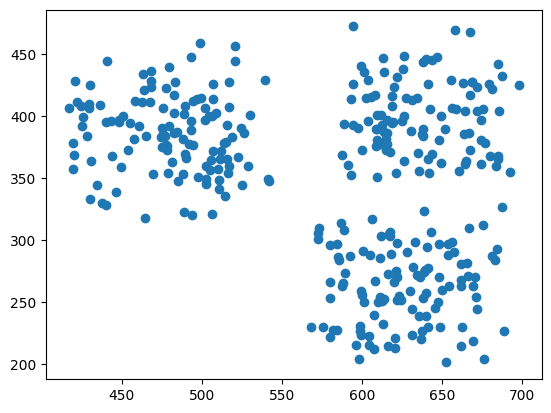

In [ ]:
#selected_points = [4, 0, 1, 10, 11, 13]
selected_points = None
if selected_points:
    x = X_train[selected_points, 0]
    y = X_train[selected_points, 1]
else:
    x = X_train[:, 0]
    y = X_train[:, 1]
plt.scatter(x, y)
# plt.xlim(0, m)
# plt.ylim(0, m)
plt.show()

## ** Calculations

In [ ]:
elems = list(range(X_train.shape[0]))
ds = DisjointSet(elems)

In [ ]:
ds.build_hierarchy(mst_edges)

In [ ]:
mst_edges

[(8, 29, 1.4142135381698608),
 (3, 8, 1.4142135381698608),
 (5, 8, 2.0),
 (0, 3, 2.0),
 (1, 5, 2.0),
 (15, 22, 2.2360680103302),
 (7, 15, 2.2360680103302),
 (7, 19, 2.2360680103302),
 (2, 22, 2.2360680103302),
 (8, 22, 2.2360680103302),
 (20, 23, 2.2360680103302),
 (6, 20, 2.2360680103302),
 (6, 27, 2.2360680103302),
 (6, 12, 2.8284270763397217),
 (6, 16, 2.8284270763397217),
 (24, 25, 2.8284270763397217),
 (1, 21, 3.0),
 (12, 26, 3.1622776985168457),
 (7, 18, 3.1622776985168457),
 (17, 23, 3.1622776985168457),
 (9, 29, 3.1622776985168457),
 (18, 24, 3.1622776985168457),
 (12, 19, 3.605551242828369),
 (18, 28, 3.605551242828369),
 (14, 21, 4.242640495300293),
 (11, 26, 4.242640495300293),
 (10, 24, 4.4721360206604),
 (4, 11, 5.0),
 (4, 13, 5.0)]

In [ ]:
ds.clusters

[{'birth': 0.0, 'death': 2.0, 'size': 1, 'parent': 33},
 {'birth': 0.0, 'death': 2.0, 'size': 1, 'parent': 34},
 {'birth': 0.0, 'death': 2.2360680103302, 'size': 1, 'parent': 38},
 {'birth': 0.0, 'death': 1.4142135381698608, 'size': 1, 'parent': 31},
 {'birth': 0.0, 'death': 5.0, 'size': 1, 'parent': 57},
 {'birth': 0.0, 'death': 2.0, 'size': 1, 'parent': 32},
 {'birth': 0.0, 'death': 2.2360680103302, 'size': 1, 'parent': 41},
 {'birth': 0.0, 'death': 2.2360680103302, 'size': 1, 'parent': 36},
 {'birth': 0.0, 'death': 5.0, 'size': 1, 'parent': 58},
 {'birth': 0.0, 'death': 3.1622776985168457, 'size': 1, 'parent': 50},
 {'birth': 0.0, 'death': 4.4721360206604, 'size': 1, 'parent': 56},
 {'birth': 0.0, 'death': 4.242640495300293, 'size': 1, 'parent': 55},
 {'birth': 0.0, 'death': 2.8284270763397217, 'size': 1, 'parent': 43},
 {'birth': 0.0, 'death': 5.0, 'size': 1, 'parent': 58},
 {'birth': 0.0, 'death': 4.242640495300293, 'size': 1, 'parent': 54},
 {'birth': 0.0, 'death': 2.236068010330

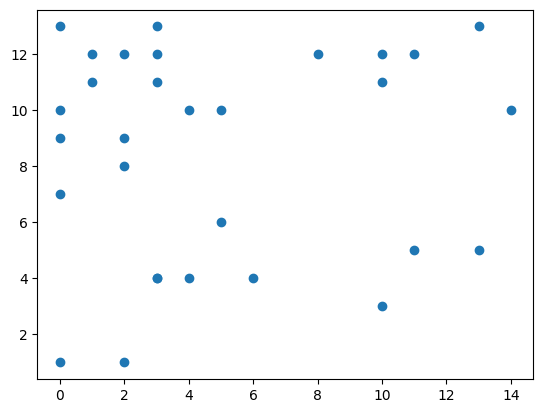

In [ ]:
#selected_points = [4, 0, 1, 10, 11, 13]
selected_points = None
if selected_points:
    x = X_train[selected_points, 0]
    y = X_train[selected_points, 1]
else:
    x = X_train[:, 0]
    y = X_train[:, 1]
plt.scatter(x, y)
# plt.xlim(0, m)
# plt.ylim(0, m)
plt.show()

In [ ]:
X_train

array([[6, 1],
       [2, 0],
       [0, 7],
       [8, 4],
       [0, 6],
       [3, 9],
       [8, 4],
       [1, 1],
       [9, 6],
       [0, 2],
       [8, 2],
       [0, 6],
       [6, 3],
       [8, 7],
       [7, 2]], dtype=int32)

In [ ]:
nodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ds = DisjointSet(nodes)
print_dict(ds.parent)

0 -> 0
1 -> 1
2 -> 2
3 -> 3
4 -> 4
5 -> 5
6 -> 6
7 -> 7
8 -> 8
9 -> 9


In [ ]:
ds.union(0, 2)
ds.union(1, 3)
ds.union(2, 3)
print_dict(ds.parent)
print_dict(ds.size)

0 -> 0
1 -> 0
2 -> 0
3 -> 1
4 -> 4
5 -> 5
6 -> 6
7 -> 7
8 -> 8
9 -> 9
0 -> 4
1 -> 2
2 -> 1
3 -> 1
4 -> 1
5 -> 1
6 -> 1
7 -> 1
8 -> 1
9 -> 1


In [ ]:
for node in nodes:
    ds.find(node)
print_dict(ds.parent)

0 -> 0
1 -> 0
2 -> 0
3 -> 0
4 -> 4
5 -> 5
6 -> 6
7 -> 7
8 -> 8
9 -> 9


## ** old works

In [ ]:
class DisjointSet:
    def __init__(self, n_points):
        self.parents = list(range(n_points))
        self.clusters_ranks = [0] * n_points
        self.clusters_sizes = [1] * n_points
        self.merge_events = []
        self.clusters_lambdas = defaultdict(list)
        self.n_points = n_points
        self.cluster_id = n_points  # Start after original points
        for i in range(n_points):
            self.clusters_lambdas[i].append((float('inf'), None))

    def find(self, u):
        if self.parents[u] != u:
            self.parents[u] = self.find(self.parents[u])
        return self.parents[u]

    def union(self, root_u, root_v):
        if self.clusters_ranks[root_u] < self.clusters_ranks[root_v]:
            root_u, root_v = root_v, root_u
        self.parents[root_v] = root_u
        self.clusters_sizes[root_u] += self.clusters_sizes[root_v]
        if self.clusters_ranks[root_u] == self.clusters_ranks[root_v]:
            self.clusters_ranks[root_u] += 1
        return root_u

    def build_hierarchy(self, mst_edges):
        active_clusters = set(range(self.n_points))
        for u, v, distance in mst_edges:
            lambda_val = 1 / distance
            root_u, root_v = self.find(u), self.find(v)

            if root_u != root_v:
                for root in (root_u, root_v):
                    if root in active_clusters:
                        birth, _ = self.clusters_lambdas[root][-1]
                        self.clusters_lambdas[root][-1] = (birth, lambda_val)
                        active_clusters.remove(root)

                new_root = self.union(root_u, root_v)
                new_size = self.clusters_sizes[new_root]
                self.clusters_lambdas[new_root].append((lambda_val, float('inf')))
                active_clusters.add(new_root)

                self.merge_events.append({
                    'left': root_u,
                    'right': root_v,
                    'root': new_root,
                    'cluster': self.cluster_id,  # Unique ID
                    'lambda_birth': lambda_val,
                    'size': new_size
                })
                self.cluster_id += 1

        assert len(active_clusters) == 1
        cl_id = active_clusters.pop()
        birth, death = self.clusters_lambdas[cl_id][-1]
        if death == float('inf'):
            self.clusters_lambdas[cl_id][-1] = (birth, 0)


    def build_hierarchy(self, mst_edges):
        active_clusters = set(range(self.n_points))
        for u, v, distance in mst_edges:
            lambda_val = 1 / distance
            root_u, root_v = self.find(u), self.find(v)

            if root_u != root_v:
                for root in (root_u, root_v):
                    if root in active_clusters:
                        birth, _ = self.clusters_lambdas[root][-1]
                        self.clusters_lambdas[root][-1] = (birth, lambda_val)
                        active_clusters.remove(root)

                new_root = self.union(root_u, root_v)
                new_size = self.clusters_sizes[new_root]
                self.clusters_lambdas[new_root].append((lambda_val, float('inf')))
                active_clusters.add(new_root)

                self.merge_events.append({
                    'left': root_u,
                    'right': root_v,
                    'root': new_root,
                    'cluster_id': self.cluster_id,  # Unique ID
                    'lambda_birth': lambda_val,
                    'size': new_size
                })
                self.cluster_id += 1

In [ ]:
def condense_and_compute_persistence(merge_events, clusters_lambdas, min_cluster_size):
    condensed_tree = []
    persistence = {}

    for event in merge_events:
        cluster_size = event['size']
        if cluster_size >= min_cluster_size:
            condensed_tree.append(event)
            new_cluster = event['cluster']
            lambda_birth = event['lambda_birth']
            lambda_death = clusters_lambdas[event['root']][-1][1]
            persistence[new_cluster] = lambda_birth - lambda_death

    return condensed_tree, persistence

In [ ]:
def select_clusters_eom(self, condensed_tree, persistence):
    """
    Select clusters using Excess of Mass method.
    """
    selected_clusters = set()
    cluster_children = {}

    # Build parent-child relationships
    for event in condensed_tree:
        parent = event['cluster']
        cluster_children[parent] = [event['left'], event['right']]

    root = condensed_tree[-1]['cluster'] if condensed_tree else None
    if not root:
        return selected_clusters

    def evaluate_cluster(cid):
        children = cluster_children.get(cid, [])
        if not children:  # Leaf
            if cid in persistence:
                selected_clusters.add(cid)
                return persistence.get(cid, 0)
            return 0

        my_persistence = persistence.get(cid, 0)
        children_persistence = sum(evaluate_cluster(child) for child in children)

        if my_persistence >= children_persistence:
            selected_clusters.add(cid)
            return my_persistence
        return children_persistence

    evaluate_cluster(root)
    return selected_clusters

In [ ]:
# version 1
class DisjointSet:
    def __init__(self, n_points):
        self.parents = list(range(n_points))
        # For Union-Find optimization (tree height)
        self.clusters_ranks = [0] * n_points
        # Track size of each cluster
        self.clusters_sizes = [1] * n_points
        # Store hierarchy steps
        self.merge_events = []

        # Track active clusters and their lambda ranges
        self.clusters_lambdas = defaultdict(list)  # {cluster_id: [(lambda_birth, lambda_death), ...]}
        self.n_points = n_points

        # Initialize singletons with infinite birth (they "exist" until first merge)
        for i in range(n_points):
            # None until death known
            self.clusters_lambdas[i].append((float('inf'), None))

    def find(self, u):
        if self.parents[u] != u:
            self.parents[u] = self.find(self.parents[u])  # Path compression
        return self.parents[u]

    def union(self, root_u, root_v):
        if self.clusters_ranks[root_u] < self.clusters_ranks[root_v]:
            root_u, root_v = root_v, root_u
        self.parents[root_v] = root_u
        # Update size
        self.clusters_sizes[root_u] += self.clusters_sizes[root_v]
        # Rank increases only if equal height
        if self.clusters_ranks[root_u] == self.clusters_ranks[root_v]:
            self.clusters_ranks[root_u] += 1
        return root_u

    def build_hierarchy(self, mst_edges):
        """
        Build hierarchy from MST
        Args:
            mst_edges: List of [(u, v, distance), ...] sorted by increasing distance
        """
        # Start assigning new IDs after original points
        cluster_id = self.n_points
        # Initially, each point is a cluster
        active_clusters = set(range(self.n_points))

        # Process MST edges in order of increasing distance
        for u, v, distance in mst_edges:
            # Lambda = inverse of distance
            lambda_val = 1 / distance
            root_u, root_v = self.find(u), self.find(v)

            if root_u != root_v:
                # Record the death of smaller clusters
                if root_u in active_clusters:
                    birth, _ = self.clusters_lambdas[root_u][-1]
                    # Death at this lambda
                    self.clusters_lambdas[root_u][-1] = (birth, lambda_val)
                    active_clusters.remove(root_u)
                if root_v in active_clusters:
                    birth, _ = self.clusters_lambdas[root_v][-1]
                    # Death at this lambda
                    self.clusters_lambdas[root_v][-1] = (birth, lambda_val)
                    active_clusters.remove(root_v)

                # Merge clusters
                new_root = self.union(root_u, root_v)
                new_size = self.clusters_sizes[new_root]

                # Birth of new cluster
                self.clusters_lambdas[new_root].append((lambda_val, float('inf')))  # Birth at this lambda
                active_clusters.add(new_root)

                # Log merge event
                self.merge_events.append({
                    'left': root_u,
                    'right': root_v,
                    'root': new_root,
                    'cluster_id': cluster_id,
                    'lambda_birth': lambda_val,
                    'size': new_size
                })
                cluster_id += 1

        # Finalize lambda ranges for remaining clusters
        for cl_id in active_clusters:
            cl_lambdas = self.clusters_lambdas.get(cl_id)
            if cl_lambdas:
                birth, death = cl_lambdas[-1]
                if death == float('inf'):
                    # Death at lambda=0
                    self.clusters_lambdas[cl_id][-1] = (birth, 0)

    def condense_and_compute_persistence(self):
        """
        Condense hierarchy and compute persistence for significant clusters.
        """
        self.condensed_tree = []
        self.persistence = {}
        # Track clusters already processed for persistence

        for event in self.merge_events:
            cluster_size = event['size']

            # Include in condensed tree if the new cluster is significant
            if cluster_size >= min_cluster_size:
                # Compute persistence only once per significant cluster
                cluster_id = event['cluster_id']
                # First birth when it becomes significant
                lambda_birth = event['lambda_birth']
                # Final death from clusters_lambdas
                root = event['root']
                lambda_death = self.clusters_lambdas[root][-1][1]
                self.persistence[cluster_id] = lambda_birth - lambda_death
                # add to condence tree
                self.condensed_tree.append(event)

    def select_clusters_eom(self):
        """
        Select clusters using Excess of Mass method.

        Returns:
            selected_clusters: Set of cluster IDs in the final clustering
        """
        selected_clusters = set()
        cluster_children = {}  # Map parent to children

        # Build parent-child relationships (reverse hierarchy)
        for event in self.condensed_tree:
            cluster_id = event['cluster_id']
            cluster_children[cluster_id] = [event['left'], event['right']]

        # Start from the root (last event's new_cluster)
        root = self.condensed_tree[-1]['cluster_id'] if self.condensed_tree else None
        if not root:
            return selected_clusters

        def evaluate_cluster(cl_id):
            children = cluster_children.get(cl_id, [])
            if not children:
                if cl_id in self.persistence:
                    selected_clusters.add(cl_id)
                    return self.persistence.get(cl_id, 0)
                return 0

            my_persistence = self.persistence.get(cl_id, 0)
            children_persistence = sum(evaluate_cluster(child) for child in children)
            if my_persistence >= children_persistence:
                selected_clusters.add(cl_id)
                return my_persistence
            return children_persistence  # Split into children

        evaluate_cluster(root)
        return selected_clusters

In [ ]:
# version 0
class DisjointSet:
    def __init__(self, n_points):
        self.parents = list(range(n_points))
        # For Union-Find optimization (tree height)
        self.clusters_ranks = [0] * n_points
        # Track size of each cluster
        self.clusters_sizes = [1] * n_points
        # Store hierarchy steps
        self.merge_events = []

        # Track active clusters and their lambda ranges
        self.clusters_lambdas = defaultdict(list)  # {cluster_id: [(lambda_birth, lambda_death), ...]}
        self.n_points = n_points

        # Initialize singletons with infinite birth (they "exist" until first merge)
        for i in range(n_points):
            # None until death known
            self.clusters_lambdas[i].append((float('inf'), None))

    def find(self, u):
        if self.parents[u] != u:
            self.parents[u] = self.find(self.parents[u])  # Path compression
        return self.parents[u]

    def union(self, root_u, root_v):
        if self.clusters_ranks[root_u] < self.clusters_ranks[root_v]:
            root_u, root_v = root_v, root_u
        self.parents[root_v] = root_u
        # Update size
        self.clusters_sizes[root_u] += self.clusters_sizes[root_v]
        # Rank increases only if equal height
        if self.clusters_ranks[root_u] == self.clusters_ranks[root_v]:
            self.clusters_ranks[root_u] += 1
        return root_u

    def build_hierarchy(self, mst_edges):
        """
        Build hierarchy from MST
        Args:
            mst_edges: List of [(u, v, distance), ...] sorted by increasing distance
        """
        # Start assigning new IDs after original points
        # cluster_id = self.n_points
        # Initially, each point is a cluster
        active_clusters = set(range(self.n_points))

        # Process MST edges in order of increasing distance
        for u, v, distance in mst_edges:
            # Lambda = inverse of distance
            lambda_val = 1 / distance
            root_u, root_v = self.find(u), self.find(v)

            if root_u != root_v:
                # Record the death of smaller clusters
                if root_u in active_clusters:
                    birth, _ = self.clusters_lambdas[root_u][-1]
                    # Death at this lambda
                    self.clusters_lambdas[root_u][-1] = (birth, lambda_val)
                    active_clusters.remove(root_u)
                if root_v in active_clusters:
                    birth, _ = self.clusters_lambdas[root_v][-1]
                    # Death at this lambda
                    self.clusters_lambdas[root_v][-1] = (birth, lambda_val)
                    active_clusters.remove(root_v)

                # Merge clusters
                new_root = self.union(root_u, root_v)
                new_size = self.clusters_sizes[new_root]

                # Birth of new cluster
                self.clusters_lambdas[new_root].append((lambda_val, float('inf')))  # Birth at this lambda
                active_clusters.add(new_root)

                # Log merge event
                self.merge_events.append({
                    'left': root_u,
                    'right': root_v,
                    'cluster': new_root,
                    'lambda_birth': lambda_val,
                    'size': new_size
                })
                # cluster_id += 1

        # Finalize lambda ranges for remaining clusters
        for cl_id in active_clusters:
            cl_lambdas = self.clusters_lambdas.get(cl_id)
            if cl_lambdas:
                birth, death = cl_lambdas[-1]
                if death == float('inf'):
                    # Death at lambda=0
                    self.clusters_lambdas[cl_id][-1] = (birth, 0)

In [ ]:
def select_clusters_eom(condensed_tree, persistence):
    """
    Select clusters using Excess of Mass method.

    Returns:
        selected_clusters: Set of cluster IDs in the final clustering
    """
    selected_clusters = set()
    cluster_children = {}  # Map parent to children

    # Build parent-child relationships (reverse hierarchy)
    for event in condensed_tree:
        cluster_id = event['cluster_id']
        cluster_children[cluster_id] = [event['left'], event['right']]

    # Start from the root (last event's new_cluster)
    root = condensed_tree[-1]['cluster'] if condensed_tree else None
    if not root:
        return selected_clusters

    def evaluate_cluster(cl_id):
        if cl_id not in persistence:  # Leaf or insignificant
            return 0
        my_persistence = persistence.get(cid, 0)


        children = cluster_children.get(cl_id, [])
        if not children:
            if cl_id in persistence
        children_persistence = sum(evaluate_cluster(child) for child in children)
        if my_persistence >= children_persistence:
            selected_clusters.add(cid)
            return my_persistence
        return children_persistence  # Split into children

    evaluate_cluster(root)
    return selected_clusters

In [ ]:
# Example usage
mst = [(0, 1, 1.0), (1, 2, 1.5), (3, 4, 2.0), (2, 3, 2.5)]
ds = DisjointSet(5)
ds.build_hierarchy(mst)

# Print results
print("Merge Events:")
for event in ds.merge_events:
    print(event)
print("\nCluster Lambda Ranges:")
for cid, ranges in ds.clusters_lambdas.items():
    if ranges and ranges[0][1] is not None:  # Include clusters with defined death
        print(f"Cluster {cid}: {ranges}")

In [ ]:
# Assume you have a list of MST edges, where each edge is a tuple (u, v, weight)
# and `num_points` is the total number of data points.
def build_dendrogram(mst_edges, num_points):
    # Sort the MST edges by increasing weight (or increasing lambda if using 1/weight)
    #mst_edges = sorted(mst_edges, key=lambda edge: edge[2])

    # Each point starts as a separate dendrogram node (leaf)
    nodes = {i: DendrogramNode(points=[i]) for i in range(num_points)}

    # We'll also use a union-find structure to track which cluster each point belongs to.
    # Extend the basic union-find to also map cluster representatives to dendrogram nodes.
    ds = DisjointSet(range(num_points))
    cluster_nodes = {i: nodes[i] for i in range(num_points)}

    # Process each edge to merge clusters
    for u, v, weight in mst_edges:
        rep_u = ds.find(u)
        rep_v = ds.find(v)
        if rep_u != rep_v:
            # Create a new dendrogram node that represents the merge of two clusters
            merged_points = cluster_nodes[rep_u].points + cluster_nodes[rep_v].points
            new_node = DendrogramNode(left=cluster_nodes[rep_u],
                                      right=cluster_nodes[rep_v],
                                      merge_distance=weight,
                                      points=merged_points)
            # Merge clusters in the union-find structure
            new_rep = ds.union(rep_u, rep_v)  # new representative after union
            cluster_nodes[new_rep] = new_node

    # At the end, there should be a single cluster containing all points.
    # We return the dendrogram root.
    root = cluster_nodes[ds.find(0)]
    return root


In [ ]:
class DisjointSet:
    def __init__(self, elems):
        self.elems = elems
        self.parent = {}
        self.size = {}
        for elem in elems:
            self.make_set(elem)

    def make_set(self, x):
        self.parent[x] = x
        self.size[x] = 1

    def find(self, x):
        if self.parent[x] == x:
            return x
        else:
            self.parent[x] = self.find(self.parent[x])
            return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)
        if root_x == root_y:
            return
        elif self.size[root_x] < self.size[root_y]:
            self.parent[root_x] = root_y
            self.size[root_y] += self.size[root_x]
        else:
            self.parent[root_y] = root_x
            self.size[root_x] += self.size[root_y]